In [59]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

import json

In [60]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [9]:
OOV_TOKEN = "<OOV>"

sentences = [
    "I like looking at cat videos",
    "The weather is gloomy today",
    "testing testing"
    ]
tokenizer = Tokenizer(num_words = 100, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(sentences)
print(tokenizer.word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences)
print(padded)

{'<OOV>': 1, 'testing': 2, 'i': 3, 'like': 4, 'looking': 5, 'at': 6, 'cat': 7, 'videos': 8, 'the': 9, 'weather': 10, 'is': 11, 'gloomy': 12, 'today': 13}
[[ 3  4  5  6  7  8]
 [ 0  9 10 11 12 13]
 [ 0  0  0  0  2  2]]


In [4]:
test_data = ["We are the champions, and we made a cat video"]
print(tokenizer.texts_to_sequences(test_data))

[[1, 1, 8, 1, 1, 1, 1, 1, 6, 1]]


In [19]:
datastore = []
with open("./etc/sarcasm_news_headlines/Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
    for item in f.readlines():
        datastore.append(json.loads(item))

sentences = []
labels = []

for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [35]:
prelim_tokenizer = Tokenizer(oov_token=OOV_TOKEN)
prelim_tokenizer.fit_on_texts(sentences)
sequences = prelim_tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences)
# vocab_size, max_length = padded.shape
# print(vocab_size, max_length)

In [53]:
SPLIT = 0.8
TRAINING_SIZE = int(SPLIT * len(sentences))
# TESTING_SIZE = len(sentences) - TRAINING_SIZE
trunc_type='post'
padding_type='post'
vocab_size = 20000
max_length = 100

# Train-test split
training_sentences = sentences[0:TRAINING_SIZE]
training_labels = labels[0:TRAINING_SIZE]
testing_sentences = sentences[TRAINING_SIZE:]
testing_labels = labels[TRAINING_SIZE:]

# Tokenize and pad the training and testing data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [54]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [55]:
print(len(training_sentences), len(training_padded), len(training_labels))

22895 22895 22895


In [64]:
# Set the number of embedding dimensions
embedding_dim = 16

# Construct the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [65]:
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose='auto')

Epoch 1/30
716/716 [==============================] - 9s 10ms/step - loss: 0.5993 - accuracy: 0.6540 - val_loss: 0.3950 - val_accuracy: 0.8155
Epoch 2/30
716/716 [==============================] - 6s 8ms/step - loss: 0.3211 - accuracy: 0.8694 - val_loss: 0.3570 - val_accuracy: 0.8436
Epoch 3/30
716/716 [==============================] - 7s 10ms/step - loss: 0.2280 - accuracy: 0.9149 - val_loss: 0.3940 - val_accuracy: 0.8374
Epoch 4/30
716/716 [==============================] - 10s 14ms/step - loss: 0.1764 - accuracy: 0.9384 - val_loss: 0.3836 - val_accuracy: 0.8461
Epoch 5/30
716/716 [==============================] - 9s 13ms/step - loss: 0.1356 - accuracy: 0.9563 - val_loss: 0.4179 - val_accuracy: 0.8501
Epoch 6/30
716/716 [==============================] - 7s 9ms/step - loss: 0.1039 - accuracy: 0.9678 - val_loss: 0.4657 - val_accuracy: 0.8436
Epoch 7/30
716/716 [==============================] - 6s 9ms/step - loss: 0.0863 - accuracy: 0.9727 - val_loss: 0.5267 - val_accuracy: 0.8339
E

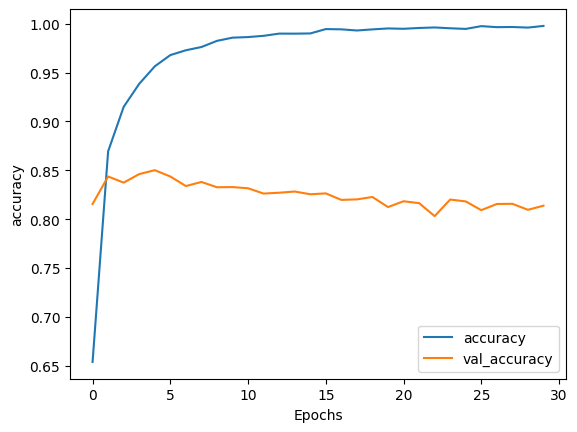

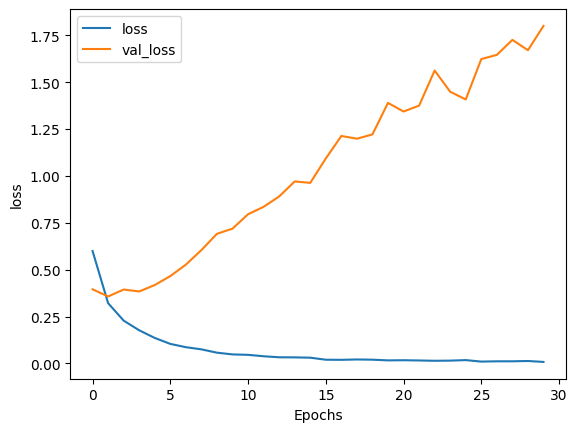

In [66]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [63]:
model.save("./models/tutorial_model")

INFO:tensorflow:Assets written to: ./models/tutorial_model\assets


INFO:tensorflow:Assets written to: ./models/tutorial_model\assets


In [68]:
loaded_model = tf.keras.models.load_model("./models./tutorial_model/")
predict_sentences = [
    "granny starting to fear spiders in the garden might be real",
    "game of thrones season finale showing this sunday night"
    ]

predict_sequences = tokenizer.texts_to_sequences(predict_sentences)
predict_padded = pad_sequences(predict_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
if (loaded_model):
    print(loaded_model.predict(predict_padded))

1/1 [==============================] - 0s 54ms/step
[[8.196414e-01]
 [8.133657e-06]]


# Text generation

In [111]:
data = open("./etc/irish-lyrics.txt", "r").read()
corpus = data.lower().split('\n')

print(corpus)
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# We add 1 for the token used to pad sequences
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

In [94]:
# This will be used to pad the other sequences
max_sequence_len = 0

input_sequences = []
for line in corpus:
    # Tokenize the current line
    tokens_from_line = tokenizer.texts_to_sequences([line])[0]
    tokens_len = len(tokens_from_line)
    max_sequence_len = max(max_sequence_len, tokens_len)

    # Create ngrams for feeding into LSTM
    # Starts from 1 because otherwise we'll get an empty list as the first element
    for token in range(1, tokens_len):
        n_gram_sequence = tokens_from_line[:token+1]
        input_sequences.append(n_gram_sequence)
    
# Pad the sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre"))

features, labels = input_sequences[:, :-1], input_sequences[:,-1]

# One-hot encode the labels
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [106]:
lstm_embedding_dim = 512
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, lstm_embedding_dim, input_length=max_sequence_len-1),
    # Bidirectional layers learn and use the best parameters in both directions
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="tanh"),
    # Use the softmax activation function here for multinomial probability output
    tf.keras.layers.Dense(total_words, activation="softmax")
])

lstm.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])
lstm.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 15, 512)           1377280   
                                                                 
 bidirectional_9 (Bidirectio  (None, 15, 256)          656384    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 2690)              174850    
                                                                 
Total params: 2,381,122
Trainable params: 2,381,122
N

In [107]:
num_epochs = 50
history = lstm.fit(features, ys, epochs=num_epochs, verbose=1)

Epoch 1/50
377/377 [==============================] - 64s 128ms/step - loss: 7.2929 - accuracy: 0.0569
Epoch 2/50
377/377 [==============================] - 61s 162ms/step - loss: 6.9837 - accuracy: 0.0597
Epoch 3/50
377/377 [==============================] - 45s 120ms/step - loss: 6.8176 - accuracy: 0.0684
Epoch 4/50
377/377 [==============================] - 40s 107ms/step - loss: 6.4902 - accuracy: 0.0763
Epoch 5/50
377/377 [==============================] - 40s 107ms/step - loss: 6.1445 - accuracy: 0.0852
Epoch 6/50
377/377 [==============================] - 43s 115ms/step - loss: 5.8625 - accuracy: 0.0910
Epoch 7/50
377/377 [==============================] - 41s 108ms/step - loss: 5.6147 - accuracy: 0.0908
Epoch 8/50
377/377 [==============================] - 45s 119ms/step - loss: 5.4169 - accuracy: 0.1009
Epoch 9/50
377/377 [==============================] - 42s 110ms/step - loss: 5.2374 - accuracy: 0.1043
Epoch 10/50
377/377 [==============================] - 40s 107ms/step - l

In [108]:
lstm.save("./models/irish2")

INFO:tensorflow:Assets written to: ./models/irish2\assets


INFO:tensorflow:Assets written to: ./models/irish2\assets


In [110]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(lstm.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 49ms/step
I've got a bad feeling about this noon where his pipes bellows chanters poured he started gone sad right gone gone right gone should right broad heard gone from life gone gone for more gone gone right right right had gone gone gone gone gone gone gone golden love gone gone golden right right right gone gone gone gone gone gone gone delight gone gone gone delight along along gone gone gone gone gone gone gone gone home gone gone gone back back nothing gone gone gone gone gone gone gone gone gone gone gone gone paddy plain gone gone gone gone gone gone gone gone gone


In [102]:
lstm2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 240, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(total_words, activation="softmax")
])

lstm2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])
lstm2.summary()
history = lstm2.fit(features, ys, epochs=num_epochs, verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 15, 240)           645600    
                                                                 
 bidirectional_6 (Bidirectio  (None, 300)              469200    
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 2690)              809690    
                                                                 
Total params: 1,924,490
Trainable params: 1,924,490
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
277/377 [=====================>........] - ETA: 7s - loss: 6.7493 - accuracy: 0.0610

KeyboardInterrupt: 